# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Logistic Regression</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Gradient Descent and Newton-Raphson</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    'external_risk_estimate',
    'revolving_utilization_of_unsecured_lines',
    'account_never_delinq_percent',
    'net_fraction_revolving_burden',
    'num_total_cc_accounts',
    'average_months_in_file'
    ]

target = 'is_bad'

X = dataset[features + [target]].copy()
y = X.pop("is_bad")
X.replace([-9, -8, -7], 0, inplace=True)

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_model = LogisticRegression()
lr_model.fit(X.loc[ix_train], y.loc[ix_train])

pred = lr_model.predict_proba(X.loc[ix_test])[:,1]
auc_score = roc_auc_score(y.loc[ix_test], pred)
print(f"Gini score: {auc_score*2-1:.2%}")

Gini score: 80.48%


### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Gradient Descent</span>

A custom implementation of Gradient Descent.

In [110]:
import numpy as np
from typing import List
from scipy.optimize import minimize
from scipy.special import logit


class LogisticRegressionGradientDescent:
    
    """
    Custom implementation of logistic regression using first-order approximation with gradient descent.
    
    This class allows you to perform logistic regression with various loss functions, including:
    1. Cross-Entropy ("ce"): Standard logistic regression.
    2. Weighted Cross-Entropy ("weighted_ce"): Adds class weights to balance the loss.
    3. Focal Cross-Entropy ("focal_ce"): Introduces focal loss to focus on hard-to-classify examples.
    4. Normalized Cross-Entropy ("normalized_ce"): Normalizes the loss based on background click-through rate.
    
    Parameters:
    - learning_rate (float): The learning rate for gradient descent (default: 0.001).
    - n_iterations (int): The number of iterations for training (default: 100).
    - regularization (str): The type of regularization, either "l1" or "l2" (default: None).
    - reg_param (float): The regularization parameter (default: 0.5).
    - use_bias (bool): Whether to fit a bias term (default: False).
    - objective (str): The choice of loss function ("ce," "weighted_ce," "focal_ce," or "normalized_ce").
    - alpha (float): The weighting factor for positive class samples in "weighted_ce" (default: 1.0).
    - gamma (float): The focusing parameter for "focal_ce" (default: 0.0).
    - bias_init (float): initialization parameter for bias (default: 0.0).
    
    Sources:
    [1] 2014. Xinran He, Stuart Bowers, Joaquin Quiñonero Candela, Junfeng Pan, Ou Jin, Tianbing Xu, Bo Liu, Tao Xu, Yanxin Shi, Antoine Atallah, and Ralf Herbrich. 
        Practical Lessons from Predicting Clicks on Ads at Facebook. Proceedings of 20th ACM SIGKDD Conference on Knowledge Discovery and Data Mining - ADKDD'14.
    [2] 2017. Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, and Piotr Dollár. 2017. Focal Loss for Dense Object Detection.
    [3] 2019. Logistic Regression From Scratch. Data Science, Machine Learning, Deep Learning. Alpha-quantum.com.
    [4] 2020. Chen Wang, Chengyuan Deng, and Shuzhen Wang. Imbalance-XGBoost: Leveraging Weighted and Focal Losses for Binary Label-Imbalanced Classification with XGBoost.

    """
    
    def __init__(
        self, learning_rate: float = 0.001, n_iterations: int = 100, regularization: str = None, 
        reg_param: float = 0.5, use_bias: bool = False, objective: str = 'ce', alpha: float = 1.0, 
        gamma: float = 0.0, weights_init: np.ndarray = None, bias_init: float = 0.0):
        
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.reg_param = reg_param
        self.use_bias = use_bias
        self.objective = objective
        self.alpha = alpha
        self.gamma = gamma
        self.weights_init = weights_init
        self.bias_init = bias_init
        self.calibration_scalar = 0.0
        self.loss_dict = []

    def _initialize_weights(self, n_features: int):
        # Initialize weights
        if self.weights_init is None:
            self.weights = np.zeros(n_features)
        elif self.weights_init.shape[0] != n_features:
            raise ValueError("The length of weights_init must match the number of input features.")
        else:
            self.weights = self.weights_init
        # Initialize bias
        self.bias = self.bias_init if self.use_bias else None
       
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def _add_regularization(self, gradient: np.ndarray) -> np.ndarray:
        if self.regularization == 'l1':
            gradient -= self.reg_param * np.sign(self.weights)
        elif self.regularization == 'l2':
            gradient -= 2 * self.reg_param * self.weights
        return gradient
    
    def _cross_entropy(self, y: np.ndarray, y_pred: np.ndarray) -> float:
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegressionGradientDescent':
                    
        if self.use_bias:
            ones = np.ones((X.shape[0], 1))
            bias_vector = self.bias_init * np.ones((X.shape[0], 1))
            X = np.column_stack((X, bias_vector))
        else:
            ones = np.ones((X.shape[0], 1))
            X = np.column_stack((X, ones))

        n_samples, n_features = X.shape
        self._initialize_weights(n_features)

        for _ in range(self.n_iterations):
            
            y_logit = np.dot(X, self.weights)
            y_pred = self._sigmoid(y_logit)
        
            if self.objective == 'ce':
                gradient = -np.dot(X.T, (y - y_pred)) / n_samples
            elif self.objective == 'weighted_ce':
                weights = np.where(y == 1, self.alpha, 1)
                gradient = -np.dot(X.T, weights * (y - y_pred)) / n_samples
            elif self.objective == 'focal_ce':
                p_t = np.where(y == 1, y_pred, 1 - y_pred)
                gradient = -np.dot(X.T, (1 - p_t) ** self.gamma * (y - y_pred)) / n_samples
            elif self.objective == 'normalized_ce':
                background_ctr = np.mean(y)
                weights_ctr = np.where(y == 1, np.log(background_ctr), np.log(1-background_ctr))
                y_logit_ctr = np.where(y == 1, background_ctr * weights_ctr, (1-background_ctr) * weights_ctr)
                y_pred_ctr = self._sigmoid(y_logit_ctr)
                gradient = -np.dot(X.T, (y - (y_pred/y_pred_ctr))) / n_samples
            else:
                raise ValueError("Invalid objective parameter")

            if self.regularization:
                gradient = self._add_regularization(gradient)
                
            self.weights -= self.learning_rate * gradient
            
            self.loss_dict.append(self._cross_entropy(y, y_pred))
            
        if self.use_bias:
            self.bias = self.weights[-1]

        return self

    # TODOs: add decision rule (next sklearn release)
    def predict(self, X: np.ndarray) -> List[int]:
        linear_model = np.dot(X, self.weights)
        y_pred = self._sigmoid(linear_model)
        return [1 if p >= 0.5 else 0 for p in y_pred]

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.use_bias:
            y_logit = np.dot(X, self.weights[:-1])
            y_logit += self.weights[-1]
        else:
            y_logit = np.dot(X, self.weights[:-1])
        return self._sigmoid(y_logit)
    
    def calibrate(self, X: np.ndarray, calibration_target: float):
        if not self.use_bias:
            raise ValueError("Calibration requires fitting a bias term.")
        
        if self.objective not in ['ce', 'weighted_ce']:
            raise ValueError("Calibration is supported for CE and weighted CE objectives only.")
        
        if not hasattr(self, 'weights'):
            raise ValueError("Model must be fitted before calibration.")
        
       # Calibration weights
        a, b = 0.0, 1.0
        cal_tar = calibration_target

        y_logit = logit(self.predict_proba(X))
        
        def to_minimize(T, A, B, scores, N, target):
            return (1 / N * sum(1 / (1 + np.exp(-(T + A + B * scores)))) - target) ** 2

        res = minimize(
            to_minimize,
            x0=1,
            args=(a, b, y_logit, len(y_logit), cal_tar),
            method='Nelder-Mead',
            options={'xtol': 1e-10, 'disp': False}
        )

        self.calibration_scalar = res.x[0]  # Update calibration_scalar
        
        calibrated_scores = y_logit + self.calibration_scalar
        calibrated_probabilities = self._sigmoid(calibrated_scores)

        return calibrated_probabilities

In [111]:
X_trn, y_trn = X.loc[ix_train].to_numpy(), y.loc[ix_train].to_numpy()
X_tst, y_tst = X.loc[ix_test].to_numpy(), y.loc[ix_test].to_numpy()

In [201]:
# %%timeit
from sklearn.metrics import log_loss, roc_auc_score

n_iterations = 100
use_bias_param = True

lr_cl = LogisticRegressionGradientDescent(
    n_iterations=n_iterations, 
    regularization='l1',
    # learning_rate=1e-3,
    reg_param=0.0001,
    use_bias=use_bias_param,
    objective='ce',
    bias_init=0.25
)
lr_cl.fit(X_trn, y_trn)

if use_bias_param:
    print(lr_cl.weights[-1], lr_cl.weights[:-1])
else:
    print(lr_cl.weights)

auc_score = roc_auc_score(y_tst, lr_cl.predict_proba(X_tst))
print(f"Gini score: {auc_score*2-1:.2%}")

log_loss_score = log_loss(y_tst, lr_cl.predict_proba(X_tst))
print(f"Log Loss: {log_loss_score:.4f}")

0.00012853261770144237 [-0.00083569  0.00343179 -0.02837508  0.0255459   0.01732565 -0.00743006]
Gini score: 61.61%
Log Loss: 0.2572


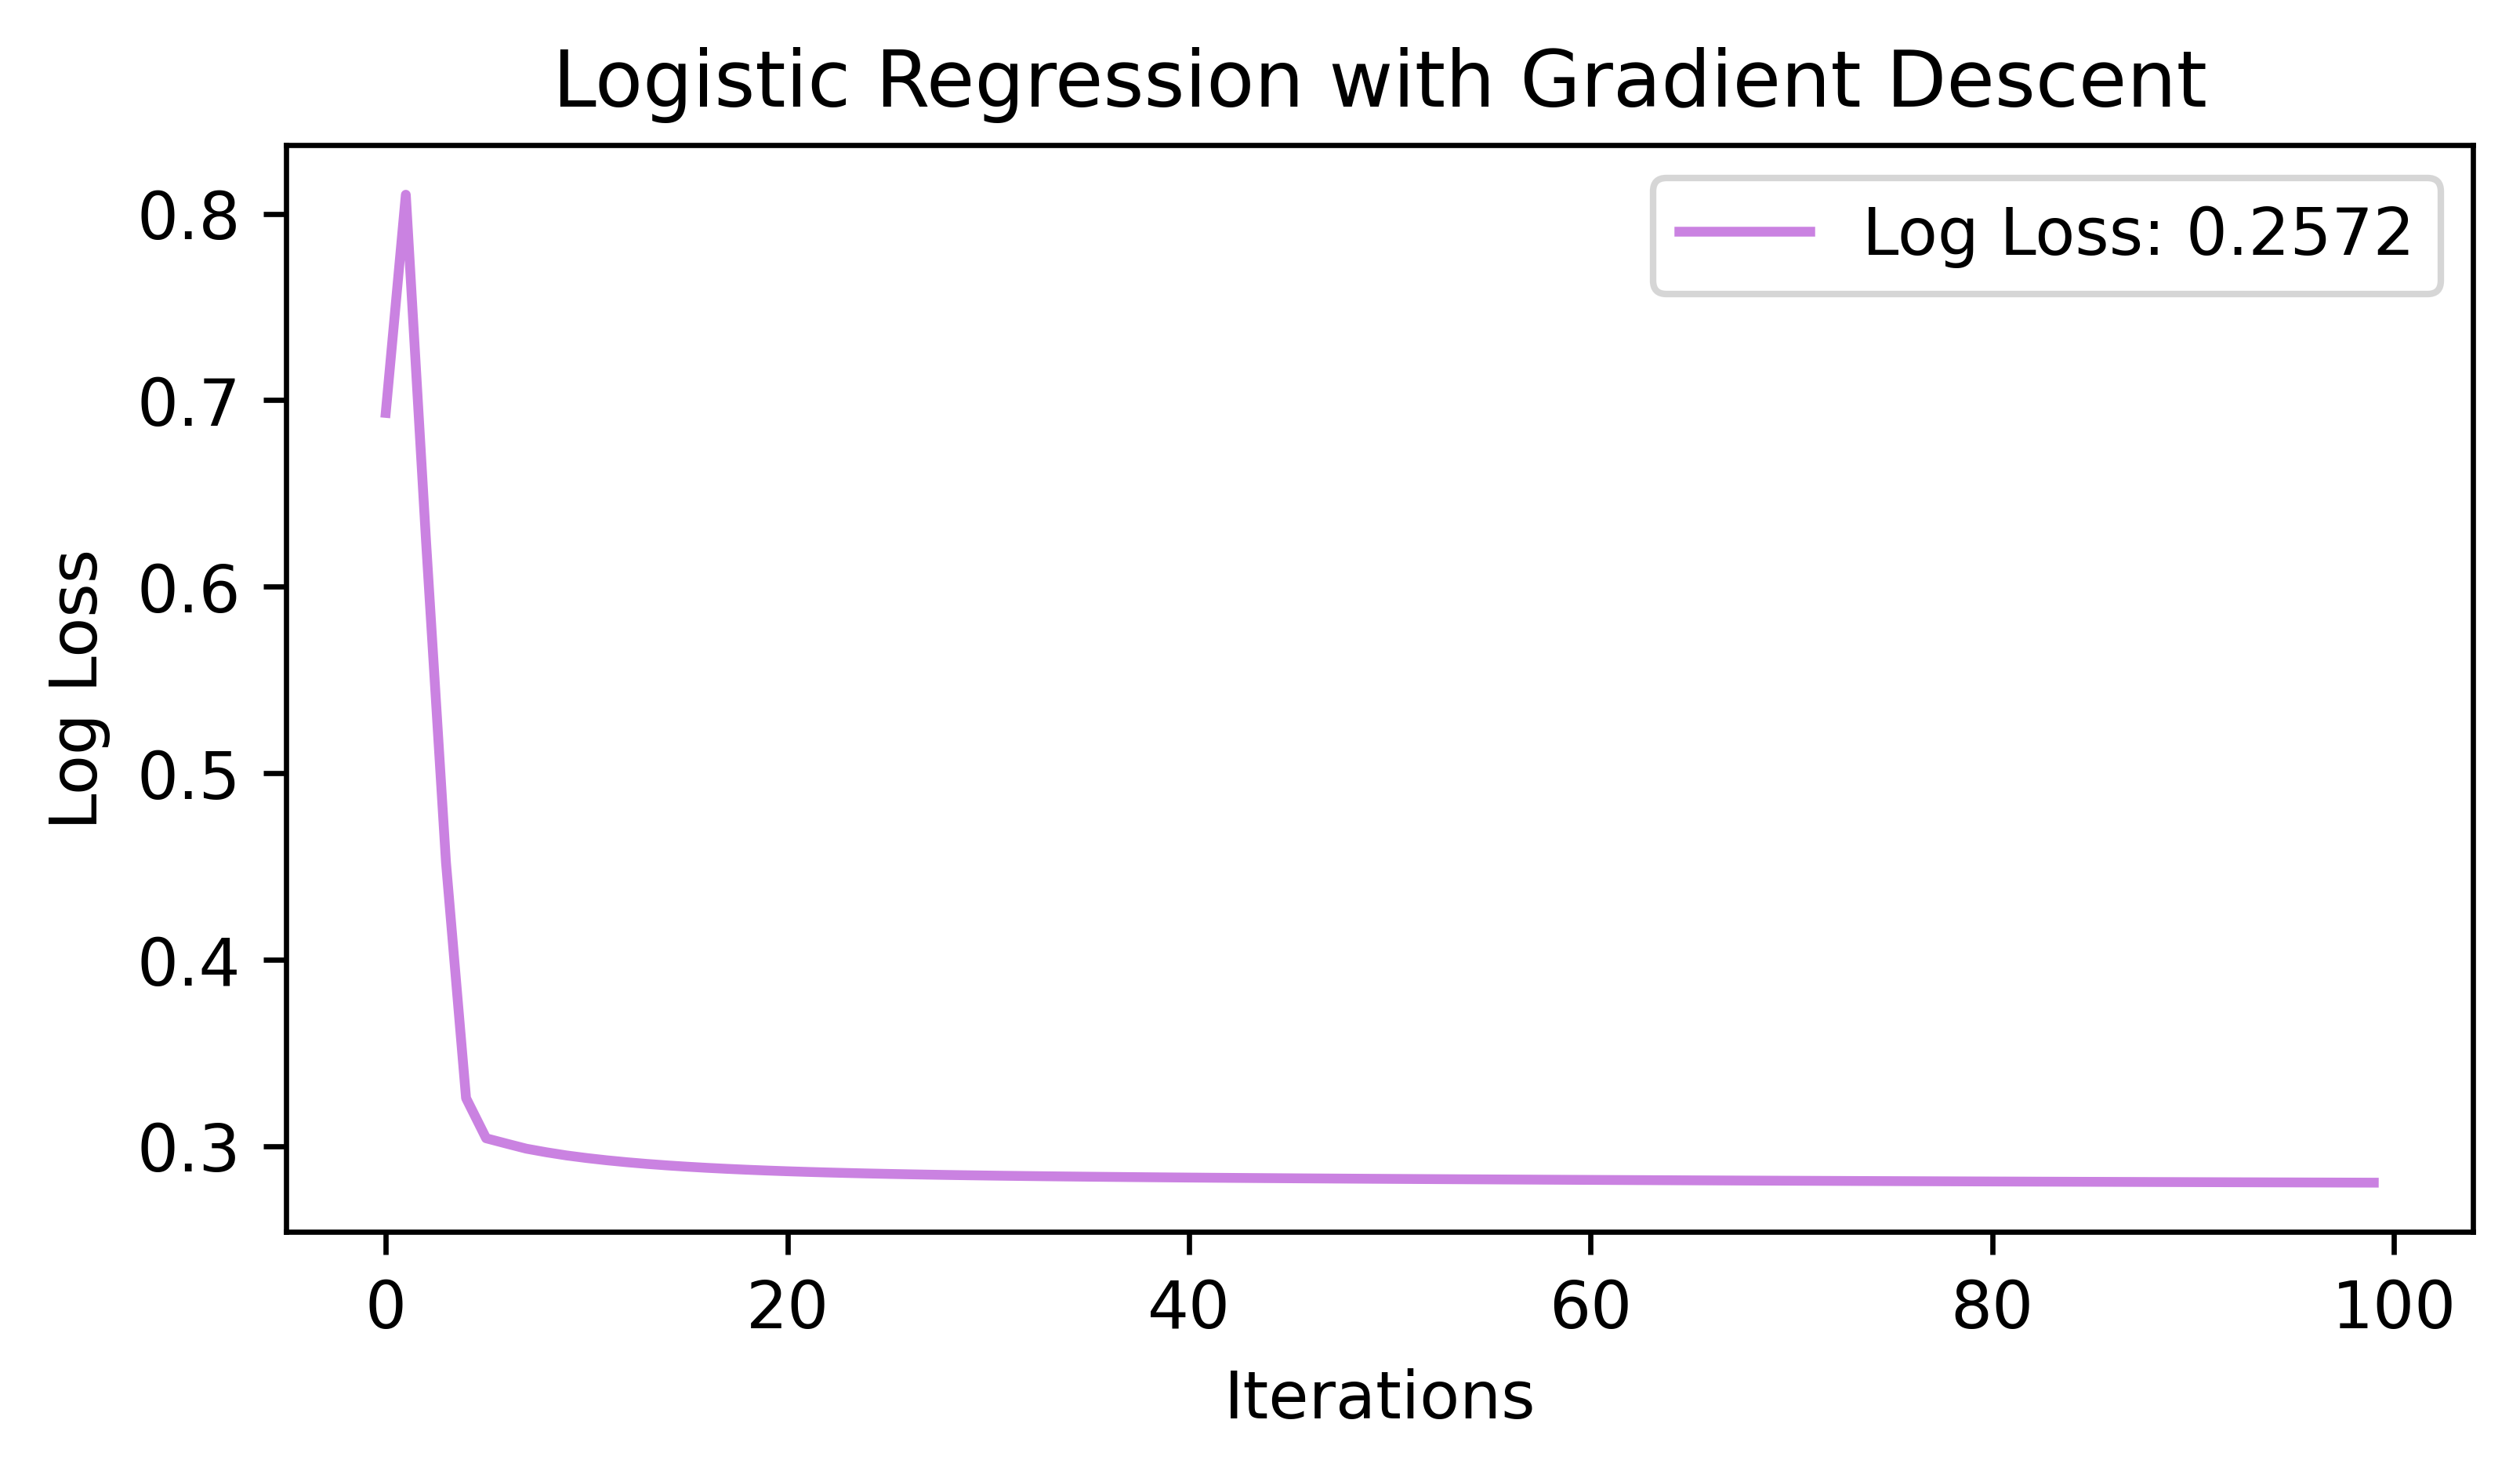

In [155]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 3), dpi=600)
plt.title("Logistic Regression with Gradient Descent")
plt.plot(lr_cl.loss_dict, color='#ca82e1', label=f"Log Loss: {log_loss_score:.4f}")
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()

### <span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Newton-Raphson</span>

A custom implementation of Newton-Raphson

In [171]:
import numpy as np
from typing import List
from scipy.optimize import minimize
from scipy.special import logit


class LogisticRegressionNewton:
    def __init__(
        self, n_iterations: int = 100, regularization: str = None,
        learning_rate: float = 0.001,
        reg_param: float = 0.5, use_bias: bool = False, objective: str = 'ce',
        alpha: float = 1.0, gamma: float = 0.0, weights_init: np.ndarray = None,
        bias_init: float = 0.0
    ):
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.reg_param = reg_param
        self.use_bias = use_bias
        self.learning_rate = learning_rate
        self.objective = objective
        self.alpha = alpha
        self.gamma = gamma
        self.weights_init = weights_init
        self.bias_init = bias_init
        self.calibration_scalar = 0.0
        self.loss_dict = []

    def _initialize_weights(self, n_features: int):
        # Initialize weights
        if self.weights_init is None:
            self.weights = np.zeros(n_features)
        elif self.weights_init.shape[0] != n_features:
            raise ValueError("The length of weights_init must match the number of input features.")
        else:
            self.weights = self.weights_init
        # Initialize bias
        self.bias = self.bias_init if self.use_bias else None

    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def _add_regularization(self, gradient: np.ndarray) -> np.ndarray:
        if self.regularization == 'l1':
            gradient -= self.reg_param * np.sign(self.weights)
        elif self.regularization == 'l2':
            gradient -= 2 * self.reg_param * self.weights
        return gradient

    def _cross_entropy(self, y: np.ndarray, y_pred: np.ndarray) -> float:
        return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LogisticRegressionNewton':

        if self.use_bias:
            ones = np.ones((X.shape[0], 1))
            bias_vector = self.bias_init * np.ones((X.shape[0], 1))
            X = np.column_stack((X, bias_vector))
        else:
            ones = np.ones((X.shape[0], 1))
            X = np.column_stack((X, ones))

        n_samples, n_features = X.shape
        self._initialize_weights(n_features)
        
        for _ in range(self.n_iterations):
            y_logit = np.dot(X, self.weights)
            y_pred = self._sigmoid(y_logit)
            
            # Calculate gradient
            gradient = -np.dot(X.T, (y - y_pred)) / n_samples
            
            # Compute the diagonal matrix for the Hessian
            S = y_pred * (1 - y_pred)
            S_matrix = np.diag(S)
            
            # Calculate Hessian
            Hessian = np.dot(X.T @ S_matrix, X) / n_samples
                    
            # Update weights using Newton-Raphson method
            try:
                # More stable and efficient to solve for delta directly
                delta = np.linalg.solve(Hessian, gradient)
                self.weights -= delta
            except np.linalg.LinAlgError:
                print("Hessian is singular, falling back to gradient descent.")
                self.weights -= self.learning_rate * gradient
            
            self.loss_dict.append(self._cross_entropy(y, y_pred))
        
        return self

    def predict(self, X: np.ndarray) -> List[int]:
        linear_model = np.dot(X, self.weights)
        y_pred = self._sigmoid(linear_model)
        return [1 if p >= 0.5 else 0 for p in y_pred]

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.use_bias:
            y_logit = np.dot(X, self.weights[:-1])
            y_logit += self.weights[-1]
        else:
            y_logit = np.dot(X, self.weights[:-1])
        return self._sigmoid(y_logit)

    def calibrate(self, X: np.ndarray, calibration_target: float):
        if not self.use_bias:
            raise ValueError("Calibration requires fitting a bias term.")

        if self.objective not in ['ce', 'weighted_ce']:
            raise ValueError("Calibration is supported for CE and weighted CE objectives only.")

        if not hasattr(self, 'weights'):
            raise ValueError("Model must be fitted before calibration.")

        # Calibration weights
        a, b = 0.0, 1.0
        cal_tar = calibration_target

        y_logit = logit(self.predict_proba(X))

        def to_minimize(T, A, B, scores, N, target):
            return (1 / N * sum(1 / (1 + np.exp(-(T + A + B * scores)))) - target) ** 2

        res = minimize(
            to_minimize,
            x0=1,
            args=(a, b, y_logit, len(y_logit), cal_tar),
            method='Nelder-Mead',
            options={'xtol': 1e-10, 'disp': False}
        )

        self.calibration_scalar = res.x[0]  # Update calibration_scalar

        calibrated_scores = y_logit + self.calibration_scalar
        calibrated_probabilities = self._sigmoid(calibrated_scores)

        return calibrated_probabilities


In [202]:
# %%timeit
from sklearn.metrics import log_loss, roc_auc_score

n_iterations = 5
use_bias_param = True

lr_cl_newton = LogisticRegressionNewton(
    n_iterations=n_iterations, 
    regularization=None,
    learning_rate=0.1,
    use_bias=use_bias_param,
    objective='ce',
    bias_init=1.0
)
lr_cl_newton.fit(X_trn, y_trn)

if use_bias_param:
    print(lr_cl_newton.weights[-1], lr_cl_newton.weights[:-1])
else:
    print(lr_cl_newton.weights)

auc_score = roc_auc_score(y_tst, lr_cl_newton.predict_proba(X_tst))
print(f"Gini score: {auc_score*2-1:.2%}")

log_loss_score = log_loss(y_tst, lr_cl_newton.predict_proba(X_tst))
print(f"Log Loss: {log_loss_score:.4f}")

6.124801551376465 [-0.01458892  2.88386637 -0.10179486  0.02425157  0.03936768 -0.00890809]
Gini score: 80.43%
Log Loss: 0.1996


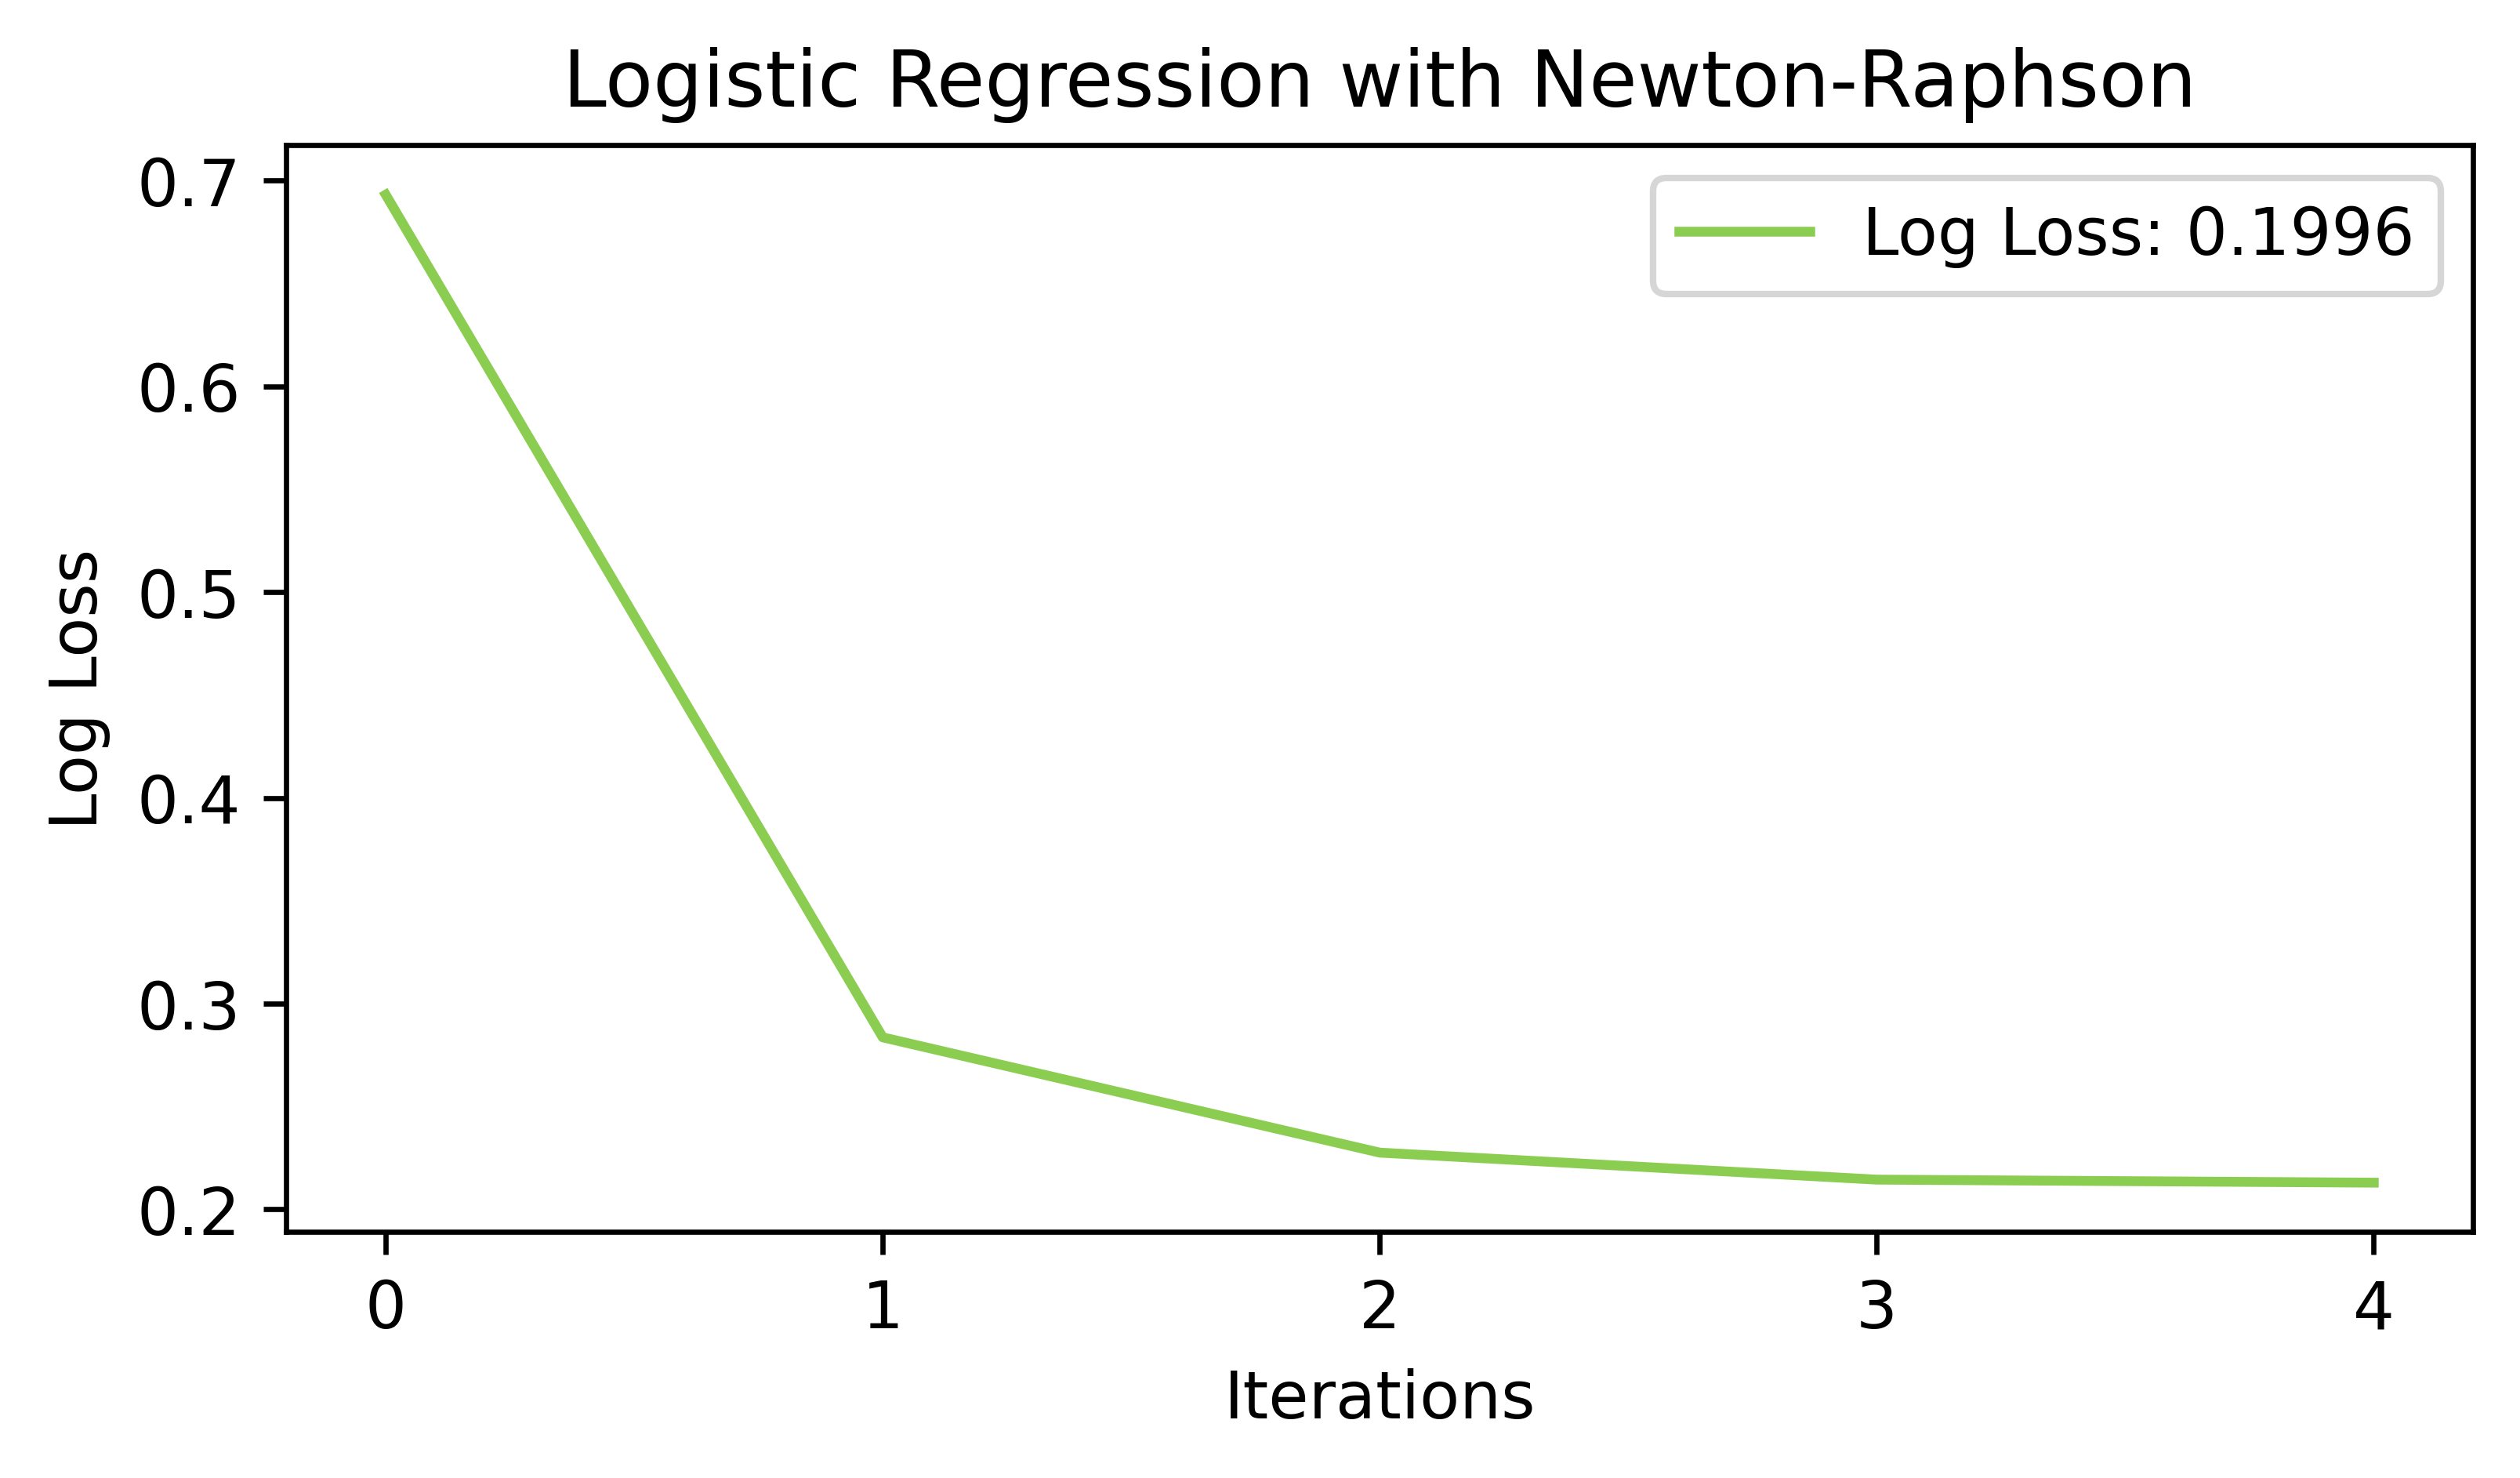

In [203]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 3), dpi=600)
plt.title("Logistic Regression with Newton-Raphson")
plt.plot(lr_cl_newton.loss_dict, color='#8bcd50', label=f"Log Loss: {log_loss_score:.4f}")
# set ticks to be 1, 2, 3 etc integers
plt.xticks(np.arange(0, n_iterations, 1))
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend()